In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection

In [2]:
(x_train_init, y_train_init), (x_test_init, y_test_init) = tf.keras.datasets.cifar10.load_data()

In [3]:
x_train_init.shape

(50000, 32, 32, 3)

In [4]:
rand_nos = np.random.choice(range(len(x_train_init)), size=4, replace=False)
random_x_train = x_train_init[rand_nos]
random_y_train = y_train_init[rand_nos]

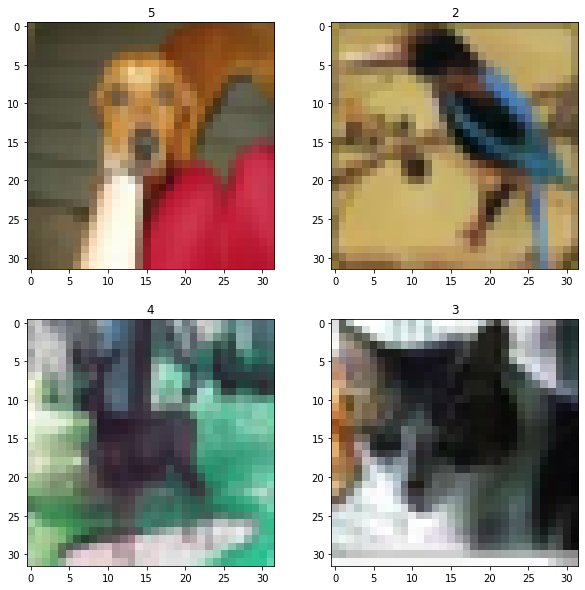

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(10, 10))

for i in range(len(axes)):
  for j in range(len(axes[0])):
    axes[i][j].imshow(random_x_train[len(axes) * i + j])
    axes[i][j].set_title(random_y_train[len(axes) * i + j][0])

In [6]:
y_one_shot_init = tf.keras.utils.to_categorical(y_train_init, num_classes=10)

y_test_one_shot = tf.keras.utils.to_categorical(y_test_init, num_classes=10)

In [7]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train_init, y_one_shot_init)

In [8]:
x_train_tensor = tf.convert_to_tensor(x_train)
x_val_tensor = tf.convert_to_tensor(x_val)

y_train_tensor = tf.convert_to_tensor(y_train)
y_val_tensor = tf.convert_to_tensor(y_val)

In [9]:
def residual_block(input, input_filters, output_filters):
  x = tf.keras.layers.BatchNormalization()(input)
  x = tf.keras.layers.Activation(activation='relu')(x)
  x = tf.keras.layers.Conv2D(filters=input_filters, kernel_size=1, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(activation='relu')(x)
  x = tf.keras.layers.Conv2D(filters=output_filters, kernel_size=3, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(activation='relu')(x)
  x = tf.keras.layers.Conv2D(filters=output_filters, kernel_size=1, padding='same')(x)

  input = tf.keras.layers.Conv2D(filters=output_filters, kernel_size=1, padding='same')(input)
  
  x = tf.keras.layers.Add()([input, x])

  return x

def attention_block(input, input_filters, output_filters, p=1, t=2, r=1):

    for i in range(p):
        input = residual_block(input, input_filters=input_filters, output_filters=output_filters)

    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk, input_filters=input_filters, output_filters=output_filters)

    # Downsampling
    output_soft_mask = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(input)
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask, input_filters=input_filters, output_filters=output_filters)


    output_skip_connection = residual_block(output_soft_mask, input_filters=input_filters, output_filters=output_filters)

    # Downsampling
    output_soft_mask = tf.keras.layers.MaxPool2D(pool_size=2, padding='same')(output_soft_mask)
    for _ in range(r):
      output_soft_mask = residual_block(output_soft_mask, input_filters=input_filters, output_filters=output_filters)

    # Upsampling
    for _ in range(r):
      output_soft_mask = residual_block(output_soft_mask, input_filters=input_filters, output_filters=output_filters)
      output_soft_mask = tf.keras.layers.UpSampling2D(size=2)(output_soft_mask)

      #print('{} {}'.format(output_soft_mask.shape, output_skip_connection))

      output_soft_mask = tf.keras.layers.Add()([output_soft_mask, output_skip_connection])


    # Upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask, input_filters=input_filters, output_filters=output_filters)
    output_soft_mask = tf.keras.layers.UpSampling2D(size=2)(output_soft_mask)

    # Output
    output_soft_mask = tf.keras.layers.Conv2D(filters=input_filters, kernel_size=1)(output_soft_mask)
    output_soft_mask = tf.keras.layers.Conv2D(filters=input_filters, kernel_size=1)(output_soft_mask)
    output_soft_mask = tf.keras.layers.Activation(activation='sigmoid')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = tf.keras.layers.Lambda(lambda x: x + 1)(output_soft_mask)
    output = tf.keras.layers.Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output, input_filters=input_filters, output_filters=output_filters)

    return output


def build_model(input_size, n_classes):
  input = tf.keras.layers.Input(shape=input_size)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same')(x)

  x = residual_block(input=x, input_filters=32, output_filters=128)
  x = attention_block(input=x, input_filters=32, output_filters=32)

  x = residual_block(input=x, input_filters=64, output_filters=128)
  x = attention_block(input=x, input_filters=64, output_filters=64)

  x = residual_block(input=x, input_filters=128, output_filters=256)
  x = attention_block(input=x, input_filters=128, output_filters=128)

  x = residual_block(input=x, input_filters=128, output_filters=256)
  x = residual_block(input=x, input_filters=256, output_filters=256)
  x = residual_block(input=x, input_filters=256, output_filters=256)

  x = tf.keras.layers.AveragePooling2D(pool_size=4)(x)
  x = tf.keras.layers.Flatten()(x)

  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)


  return tf.keras.models.Model(input, output)


In [10]:
model = build_model(x_train_tensor.shape[1:], 10)

In [16]:
batch_size = 32
lr = 0.0001
epochs = 20

In [17]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=10e-7, min_delta=0.01, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=5, verbose=1)
callbacks= [lr_reducer, early_stopper]

In [18]:
optim = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1, horizontal_flip=True, 
                                                           rotation_range=0.2, width_shift_range=0.2, height_shift_range=0.2,
                                                           zoom_range=0.2)
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_data_gen.flow(x_train_tensor, y_train_tensor)
val_gen = val_data_gen.flow(x_val_tensor, y_val_tensor)

In [20]:
model.fit(train_gen, validation_data=val_gen, batch_size=batch_size, 
          steps_per_epoch=train_gen.n // batch_size, validation_steps=val_gen.n // batch_size,
          callbacks=callbacks, epochs=epochs)

Epoch 1/20
1171/1171 [==============================] - 664s 567ms/step - loss: 1.2576 - accuracy: 0.5447 - val_loss: 1.2132 - val_accuracy: 0.5716 - lr: 1.0000e-04
Epoch 2/20
1171/1171 [==============================] - 661s 564ms/step - loss: 1.1562 - accuracy: 0.5858 - val_loss: 0.9971 - val_accuracy: 0.6382 - lr: 1.0000e-04
Epoch 3/20
1171/1171 [==============================] - 662s 565ms/step - loss: 1.0885 - accuracy: 0.6144 - val_loss: 1.1515 - val_accuracy: 0.6060 - lr: 1.0000e-04
Epoch 4/20
1171/1171 [==============================] - 661s 565ms/step - loss: 1.0405 - accuracy: 0.6292 - val_loss: 0.9673 - val_accuracy: 0.6558 - lr: 1.0000e-04
Epoch 5/20
1171/1171 [==============================] - 661s 564ms/step - loss: 1.0061 - accuracy: 0.6434 - val_loss: 0.9341 - val_accuracy: 0.6635 - lr: 1.0000e-04
Epoch 6/20
1171/1171 [==============================] - 662s 565ms/step - loss: 0.9704 - accuracy: 0.6570 - val_loss: 0.8814 - val_accuracy: 0.6852 - lr: 1.0000e-04
Epoch 7/20

In [21]:
x_test_scaled = x_test_init / 255.0
x_test_tensor = tf.convert_to_tensor(x_test_scaled)

y_test_tensor = tf.convert_to_tensor(y_test_one_shot)

In [22]:
model.evaluate(x=x_test_tensor, y=y_test_tensor)

313/313 [==============================] - 51s 163ms/step - loss: 0.6467 - accuracy: 0.7863


[0.6467199921607971, 0.786300003528595]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
model_dir = root_dir + 'Resnet-With-Attention-Masks/model'

In [24]:
model.save(model_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Resnet-With-Attention-Masks/model/assets


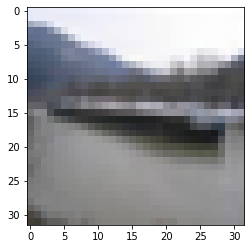

In [47]:
rand_int = np.random.choice(range(len(x_test_init)), size=1)[0]
rand_img = x_test_init[rand_int]
plt.imshow(rand_img)

In [48]:
rand_img_scaled = x_test_scaled[rand_int].reshape((1,) + x_test_scaled.shape[1:])
rand_img_label = y_test_one_shot[rand_int].argmax(axis=-1)

In [52]:
prediction = model.predict(rand_img_scaled)
predicted_label = prediction.argmax(axis=-1)
confidence = prediction[0][predicted_label]

print('Actual label: {}, Predicted label: {}, oonfidence: {}'.format(rand_img_label, predicted_label, confidence))

Actual label: 8, Predicted label: [8], oonfidence: [0.9862031]
